##Importing all the Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
from PIL import Image
import os
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from random import randint
from skimage.io import imread
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from skimage.transform import resize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix

##Connecting with Kaggle

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json 

mkdir: cannot create directory ‘/root/.kaggle’: File exists


##Downloading the Dataset

In [5]:
! kaggle competitions download histopathologic-cancer-detection

100% 6.30G/6.31G [00:28<00:00, 236MB/s]
100% 6.31G/6.31G [00:28<00:00, 240MB/s]


##Extracting all the Files

In [6]:
! unzip histopathologic-cancer-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d

Printing Total Images in Training Folder

In [7]:
print("Train Size: {}".format(len(os.listdir('../content/train'))))

Train Size: 220025


Printing Total Images in Test Folder

In [8]:
print("Test Size: {}".format(len(os.listdir('../content/test'))))

Test Size: 57458


###Creating a DataFrame of all Train Image Labels

In [9]:
df_train = pd.read_csv('/content/train_labels.csv')
print(df_train.shape) 

(220025, 2)


In [10]:
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


##Printing Random Images for both Positive (Cancerous) & Negative (Non-Cancerous) Samples

In [11]:
train_dir = '/content/train'
print("Train Size: {}".format(len(os.listdir(train_dir))))

Train Size: 220025


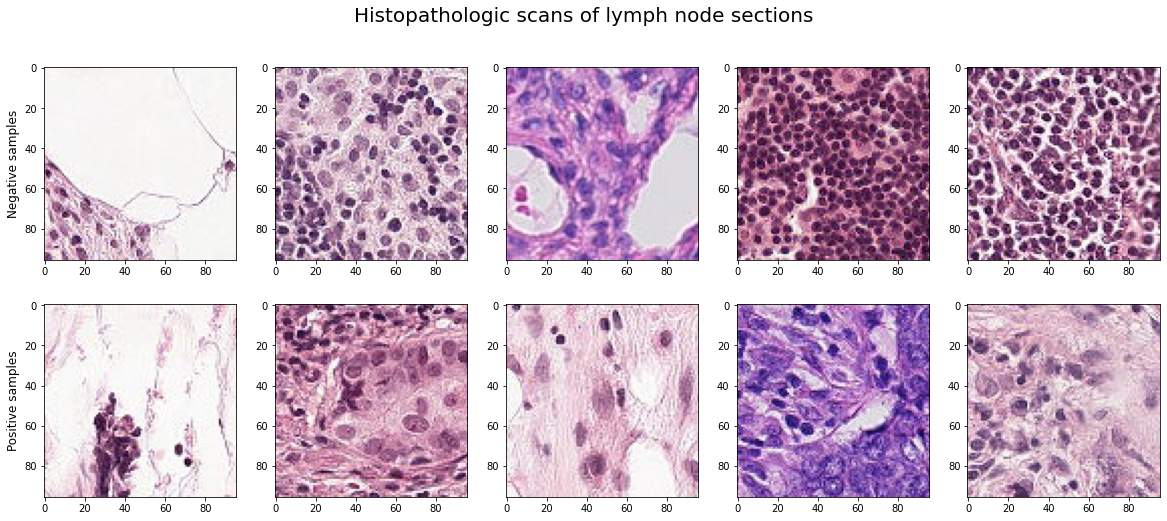

In [12]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)


# Negatives
for i, idx in enumerate(df_train[df_train['label'] == 0]['id'][:5]):
    path = os.path.join(train_dir, idx)
    img = imread(path +'.tif')
    ax[0,i].imshow(img)
ax[0,0].set_ylabel('Negative samples', size='large')


# # Positives
for i, idx in enumerate(df_train[df_train['label'] == 1]['id'][:5]):
    path = os.path.join(train_dir, idx)
    img = imread(path+'.tif')
    ax[1,i].imshow(img)
ax[1,0].set_ylabel('Positive samples', size='large');

##Counting Number of Samples in Each Label

In [13]:
df_train['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


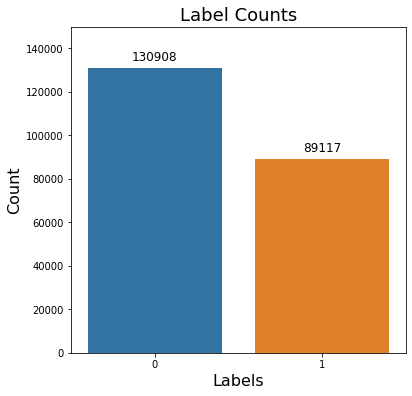

In [14]:
fig = plt.figure(figsize = (6,6)) 
ax = sns.countplot(df_train.label).set_title('Label Counts', fontsize = 18)
plt.annotate(df_train.label.value_counts()[0],
            xy = (0,df_train.label.value_counts()[0] + 2000),
            va = 'bottom',
            ha = 'center',
            fontsize = 12)
plt.annotate(df_train.label.value_counts()[1],
            xy = (1,df_train.label.value_counts()[1] + 2000),
            va = 'bottom',
            ha = 'center',
            fontsize = 12)
plt.ylim(0,150000)
plt.ylabel('Count', fontsize = 16)
plt.xlabel('Labels', fontsize = 16)
plt.show()

There is a class imbalance in the training data with significantly more non-cancerous images (label '0') versus cancerous (label '1'). We will reduce the size of label 0 by random undersampling of that set in order to match the same size as the set of images with label 1.

In [ ]:
#df_train['label'].value_counts().plot(kind='pie')

In [ ]:
# shutil.rmtree('/content/base_dir')

##Balancing the labels using Random Sampling and reduce the memory usage or potential crash.
##Taking 80K images from both labels.

In [15]:
SAMPLE_SIZE = 80000
# taking a random sample of class 0
df_0 = df_train[df_train['label'] == 0].sample(SAMPLE_SIZE, random_state = 32)
# taking a random sample of class 1
df_1 = df_train[df_train['label'] == 1].sample(SAMPLE_SIZE, random_state = 32)

# concat the dataframes
df_train = pd.concat([df_0, df_1], axis = 0).reset_index(drop = True)
# shuffle
df_train = shuffle(df_train)

df_train['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

In [ ]:
# shutil.rmtree('/content/base_dir')

In [16]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)

#Folder Structure

'''
    * base_dir
        |-- train_dir
            |-- 0   #Non-Cancerous
            |-- 1   #Cancerous
'''
# creating a path to 'base_dir' which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# create new folders inside train_dir
no_tumor = os.path.join(train_dir, '0')
os.mkdir(no_tumor)
has_tumor = os.path.join(train_dir, '1')
os.mkdir(has_tumor)

In [ ]:
# # take a random sample of class 0 with size equal to num samples in class 1
# df_0 = df_test[df_test['label'] == 0].sample(26197, random_state = 32)
# # filter out class 1
# df_1 = df_test[df_test['label'] == 1].sample(17808, random_state = 32)

# # concat the dataframes
# df_test = pd.concat([df_0, df_1], axis = 0).reset_index(drop = True)
# # shuffle
# df_test = shuffle(df_test)

# df_test['label'].value_counts()


##Transfering the Respective Images into their Respective Folders

In [17]:
# # Transfer the train images
  
    # the id in the csv file does not have the .tif extension therefore adding it here
file_name = df_train['id'] + '.tif'

label_value=df_train['label']
        # source path to image
for i in range(len(file_name)):
  src = os.path.join('/content/train', file_name[i])
    # destination path to image
  dest = os.path.join(train_dir,str(label_value[i]), file_name[i])
    # copy the image from the source to the destination
  shutil.copyfile(src, dest)

In [18]:
print("Train Size (0): {}".format(len(os.listdir('/content/base_dir/train_dir/0'))))
print("Train Size (1): {}".format(len(os.listdir('/content/base_dir/train_dir/1'))))

Train Size (0): 80000
Train Size (1): 80000


In [ ]:
# # test_dir
# test_dir = os.path.join(base_dir, 'test_dir')
# os.mkdir(test_dir)

# # create new folders inside train_dir
# no_tumor = os.path.join(test_dir, '0')
# os.mkdir(no_tumor)
# has_tumor = os.path.join(test_dir, '1')
# os.mkdir(has_tumor)

In [ ]:
# test_dir = '/content/base_dir/test_dir'

In [ ]:
# file_name = df_test['id']+'.tif'

# label_value=df_test['label']
#     # source path to image
# for i in range(len(file_name)):
#   src = os.path.join('/content/train', file_name[i])
  
#     # destination path to image
#   dest = os.path.join(test_dir, str(label_value[i]), file_name[i])
#     # copy the image from the source to the destination
#   shutil.copyfile(src, dest)

In [ ]:
# print("Test Size (0): {}".format(len(os.listdir('/content/base_dir/test_dir/0'))))
# print("Test Size (1): {}".format(len(os.listdir('/content/base_dir/test_dir/1'))))

##Applying Image Normalization & Augmentation

In [19]:
train_datagen = ImageDataGenerator(
    featurewise_std_normalization=True,
    samplewise_std_normalization=True,
    featurewise_center=True,
    samplewise_center=True,
    #shear_range = 0.6,
    zoom_range = 0.6,
    rotation_range=10,
    horizontal_flip=True,
    # vertical_flip=True,
    rescale = 1./255,
    validation_split=0.2) #Splitting Validation Set for Testing Model
train_generator = train_datagen.flow_from_directory(train_dir,
                                         target_size = (96,96),
                                         batch_size = 32,
                                         class_mode = 'binary')
validation_generator = train_datagen.flow_from_directory(train_dir,
                                                         target_size = (96,96),
                                                         batch_size = 32,
                                                         class_mode = 'binary',
                                                         subset = 'validation', 
                                                         shuffle = False)
# test_gen = train_datagen.flow_from_directory(test_dir,
#                                              target_size = (96,96),
#                                              batch_size = 32,
#                                              class_mode = 'binary',
#                                              shuffle = False)

Found 160000 images belonging to 2 classes.
Found 32000 images belonging to 2 classes.


#Applying Models

##CNN Model

In [20]:
model=Sequential()
model.add(Conv2D(32,(3,3),strides=1,padding='Same',activation='relu',input_shape=(96, 96, 3)))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

model.summary()

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999) , loss = "binary_crossentropy", metrics=["accuracy"])


callback = EarlyStopping(monitor='val_accuracy', patience=5)

seed = 1234
np.random.seed(seed)
history = model.fit(train_generator, validation_data=(validation_generator), epochs=20, batch_size=64, callbacks=[callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                      

##Making Model Accuracy and Loss Graph

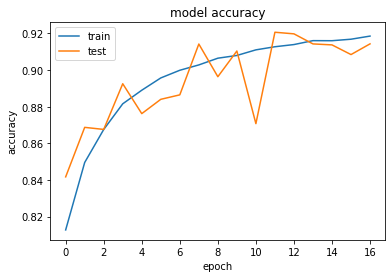

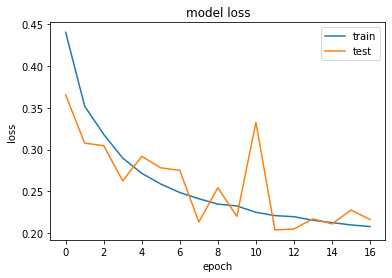

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

##Evaluating Best Accuracy on Validation Set

In [22]:
val_loss, val_acc = \
model.evaluate_generator(validation_generator)
print('val_loss: ', val_loss)
print('val_acc: ', val_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


val_loss:  0.21313220262527466
val_acc:  0.9161875247955322


##Making Predictions on Validation Set

In [23]:
predictions = model.predict_generator(validation_generator, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


1000/1000 [==============================] - 88s 88ms/step


In [24]:
predictions.shape
validation_generator.class_indices

{'0': 0, '1': 1}

In [25]:
prediction = predictions.flatten()
print(predictions.round(2))

[[0.  ]
 [0.  ]
 [0.  ]
 ...
 [0.98]
 [0.83]
 [0.24]]


In [26]:
predictions = np.where(predictions >0.5, 1, 0) #Converting Prediction in Binary Form
print(predictions)

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [0]]


In [27]:
df_preds = pd.DataFrame(predictions) #Putting Predictions In Dataframe
df_preds.head(20)

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [28]:
y_true = validation_generator.classes
y_pred = df_preds

In [29]:
#ROC_AUC Score
print('ROC AUC Score: ', roc_auc_score(y_true, y_pred))

ROC AUC Score:  0.91275


##ROC Graph

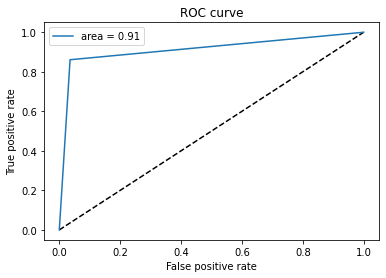

In [30]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.2f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

##Confusion Matrix

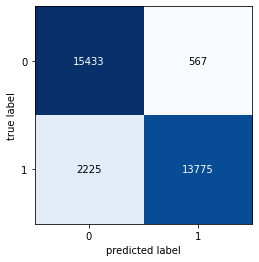

In [31]:
cm = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                # show_absolute=True,
                                # show_normed=True,
                                # colorbar=True,
                              #  cmap = 'Dark2'
                              )
plt.show()

##Classification Report

In [32]:
# Generate a classification report
report = classification_report(y_true, y_pred, target_names = ['no_tumor', 'has_tumor'])
print(report)

              precision    recall  f1-score   support

    no_tumor       0.87      0.96      0.92     16000
   has_tumor       0.96      0.86      0.91     16000

    accuracy                           0.91     32000
   macro avg       0.92      0.91      0.91     32000
weighted avg       0.92      0.91      0.91     32000



In [33]:
model.save('/content/drive/MyDrive/Colab Notebooks/Models/model_main_adam.h5') #Saving the Model

##CNN Model (Adagrad Optimizer)

In [48]:
model7=Sequential()
model7.add(Conv2D(32,(3,3),strides=1,padding='Same',activation='relu',input_shape=(96, 96, 3)))
model7.add(MaxPooling2D(2,2))
model7.add(BatchNormalization())
model7.add(Conv2D(64,(3,3), strides=1,padding= 'Same', activation='relu'))
model7.add(MaxPooling2D(2,2))
model7.add(BatchNormalization())
model7.add(Conv2D(128,(3,3), strides=1,padding= 'Same', activation='relu'))
model7.add(MaxPooling2D(2,2))
model7.add(BatchNormalization())
model7.add(Conv2D(256,(3,3), strides=1,padding= 'Same', activation='relu'))
model7.add(MaxPooling2D(2,2))
model7.add(BatchNormalization())
model7.add(Flatten())
model7.add(Dropout(0.2))
model7.add(Dense(512, activation = "relu"))
model7.add(Dropout(0.2))
model7.add(Dense(1, activation = "sigmoid"))

model7.summary()

model7.compile(optimizer = tf.keras.optimizers.Adagrad(0.001) , loss = "binary_crossentropy", metrics=["accuracy"])


callback = EarlyStopping(monitor='val_accuracy', patience=5)

seed = 1234
np.random.seed(seed)
history = model7.fit(train_generator, validation_data=(validation_generator), epochs=20, batch_size=64, callbacks=[callback])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                      

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


5000/5000 [==============================] - 530s 106ms/step - loss: 0.5038 - accuracy: 0.7677 - val_loss: 0.4050 - val_accuracy: 0.8184
Epoch 2/20
5000/5000 [==============================] - 522s 104ms/step - loss: 0.4229 - accuracy: 0.8086 - val_loss: 0.3704 - val_accuracy: 0.8365
Epoch 3/20
5000/5000 [==============================] - 526s 105ms/step - loss: 0.4002 - accuracy: 0.8205 - val_loss: 0.3551 - val_accuracy: 0.8448
Epoch 4/20
5000/5000 [==============================] - 527s 105ms/step - loss: 0.3858 - accuracy: 0.8270 - val_loss: 0.3452 - val_accuracy: 0.8482
Epoch 5/20
5000/5000 [==============================] - 524s 105ms/step - loss: 0.3740 - accuracy: 0.8325 - val_loss: 0.3363 - val_accuracy: 0.8536
Epoch 6/20
5000/5000 [==============================] - 523s 105ms/step - loss: 0.3664 - accuracy: 0.8366 - val_loss: 0.3281 - val_accuracy: 0.8567
Epoch 7/20
5000/5000 [==============================] - 522s 104ms/step - loss: 0.3574 - accuracy: 0.8425 - val_loss: 0.323

##Making Model Accuracy and Loss Graph

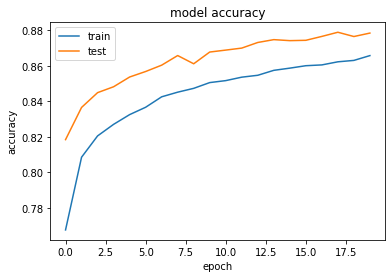

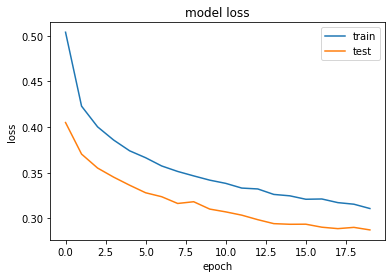

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

##Evaluating Best Accuracy on Validation Set

In [50]:
val_loss, val_acc = \
model7.evaluate_generator(validation_generator)
print('val_loss: ', val_loss)
print('val_acc: ', val_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


val_loss:  0.28543776273727417
val_acc:  0.8774687647819519


##Making Predictions on Validation Set

In [51]:
predictions = model7.predict_generator(validation_generator, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


1000/1000 [==============================] - 93s 93ms/step


In [52]:
predictions.shape

(32000, 1)

In [53]:
validation_generator.class_indices

{'0': 0, '1': 1}

In [54]:
prediction = predictions.flatten()
print(predictions.round(2))

[[0.05]
 [0.09]
 [0.  ]
 ...
 [0.6 ]
 [0.87]
 [0.59]]


In [55]:
predictions = np.where(predictions >0.5, 1, 0) #Converting Prediction in Binary Form
print(predictions)

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


In [56]:
df_preds = pd.DataFrame(predictions) #Putting Predictions In Dataframe
df_preds.head(20)

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [57]:
y_true = validation_generator.classes
y_pred = df_preds

In [58]:
#ROC_AUC Score
print('ROC AUC Score: ', roc_auc_score(y_true, y_pred))

ROC AUC Score:  0.88153125


##ROC Graph

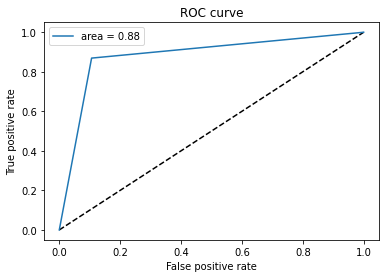

In [59]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.2f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

##Confusion Matrix

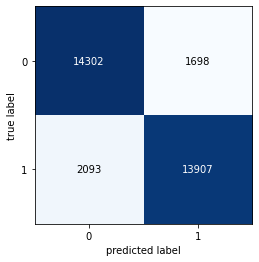

In [60]:
cm = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                # show_absolute=True,
                                # show_normed=True,
                                # colorbar=True,
                              #  cmap = 'Dark2'
                              )
plt.show()

##Classification Report

In [61]:
# Generate a classification report
report = classification_report(y_true, y_pred, target_names = ['no_tumor', 'has_tumor'])
print(report)

              precision    recall  f1-score   support

    no_tumor       0.87      0.89      0.88     16000
   has_tumor       0.89      0.87      0.88     16000

    accuracy                           0.88     32000
   macro avg       0.88      0.88      0.88     32000
weighted avg       0.88      0.88      0.88     32000



In [ ]:
# model7.save('model_main_adagrad.h5')

In [ ]:
model7.save('/content/drive/MyDrive/Colab Notebooks/Models/model_main_adagrad.h5')

##CNN Model (Nadam Optimizer)

In [20]:
model16=Sequential()
model16.add(Conv2D(32,(3,3),strides=1,padding='Same',activation='relu',input_shape=(96, 96, 3)))
model16.add(MaxPooling2D(2,2))
model16.add(BatchNormalization())
model16.add(Conv2D(64,(3,3), strides=1,padding= 'Same', activation='relu'))
model16.add(MaxPooling2D(2,2))
model16.add(BatchNormalization())
model16.add(Conv2D(128,(3,3), strides=1,padding= 'Same', activation='relu'))
model16.add(MaxPooling2D(2,2))
model16.add(BatchNormalization())
model16.add(Conv2D(256,(3,3), strides=1,padding= 'Same', activation='relu'))
model16.add(MaxPooling2D(2,2))
model16.add(BatchNormalization())
model16.add(Flatten())
model16.add(Dropout(0.2))
model16.add(Dense(512, activation = "relu"))
model16.add(Dropout(0.2))
model16.add(Dense(1, activation = "sigmoid"))

model16.summary()

model16.compile(optimizer = tf.keras.optimizers.Nadam(0.0001) , loss = "binary_crossentropy", metrics=["accuracy"])


callback = EarlyStopping(monitor='val_accuracy', patience=5)

seed = 1234
np.random.seed(seed)
history = model16.fit(train_generator, validation_data=(validation_generator), epochs=20, batch_size=64, callbacks=[callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                        

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
5000/5000 [==============================] - 712s 140ms/step - loss: 0.4656 - accuracy: 0.7915 - val_loss: 0.3780 - val_accuracy: 0.8336
Epoch 2/20
5000/5000 [==============================] - 621s 124ms/step - loss: 0.3604 - accuracy: 0.8413 - val_loss: 0.3240 - val_accuracy: 0.8611
Epoch 3/20
5000/5000 [==============================] - 578s 116ms/step - loss: 0.3240 - accuracy: 0.8605 - val_loss: 0.2963 - val_accuracy: 0.8729
Epoch 4/20
5000/5000 [==============================] - 564s 113ms/step - loss: 0.2996 - accuracy: 0.8726 - val_loss: 0.2825 - val_accuracy: 0.8817
Epoch 5/20
5000/5000 [==============================] - 555s 111ms/step - loss: 0.2842 - accuracy: 0.8807 - val_loss: 0.2631 - val_accuracy: 0.8893
Epoch 6/20
5000/5000 [==============================] - 553s 111ms/step - loss: 0.2716 - accuracy: 0.8868 - val_loss: 0.2580 - val_accuracy: 0.8967
Epoch 7/20
5000/5000 [==============================] - 550s 110ms/step - loss: 0.2614 - accuracy: 0.8913 - val_

##Making Model Accuracy and Loss Graph

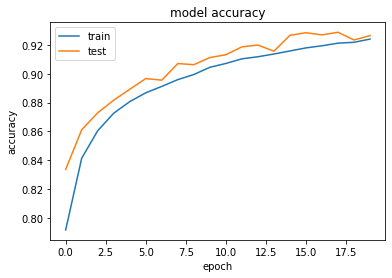

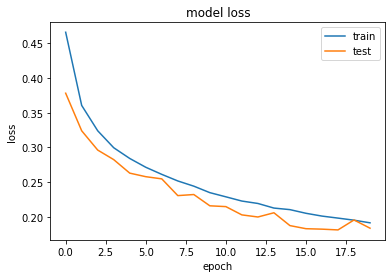

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

##Evaluating Best Accuracy on Validation Set


In [22]:
val_loss, val_acc = \
model16.evaluate_generator(validation_generator)
print('val_loss: ', val_loss)
print('val_acc: ', val_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


val_loss:  0.18505364656448364
val_acc:  0.9272812604904175


##Making Predictions on Validation Set

In [23]:
predictions = model16.predict_generator(validation_generator, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


1000/1000 [==============================] - 86s 86ms/step


In [24]:
predictions.shape

(32000, 1)

In [25]:
validation_generator.class_indices

{'0': 0, '1': 1}

In [26]:
prediction = predictions.flatten()
print(predictions.round(2))

[[0.01]
 [0.01]
 [0.  ]
 ...
 [1.  ]
 [0.77]
 [0.38]]


In [27]:
predictions = np.where(predictions > 0.5, 1, 0) #Converting Prediction in Binary Form
print(predictions)

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [0]]


In [28]:
df_preds = pd.DataFrame(predictions) #Putting Predictions In Dataframe
df_preds.head(20)

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [29]:
y_true = validation_generator.classes
y_pred = df_preds

In [30]:
#ROC_AUC Score
print('ROC AUC Score: ', roc_auc_score(y_true, y_pred))

ROC AUC Score:  0.9256249999999999


##ROC Graph

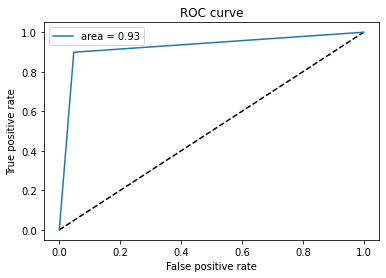

In [31]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.2f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

##Confusion Matrix

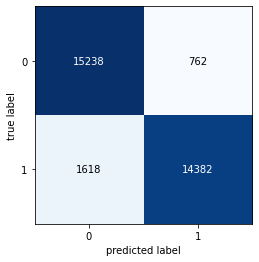

In [32]:
cm = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                # show_absolute=True,
                                # show_normed=True,
                                # colorbar=True,
                              #  cmap = 'Dark2'
                              )
plt.show()

##Classification Report

In [33]:
# Generate a classification report
report = classification_report(y_true, y_pred, target_names = ['no_tumor', 'has_tumor'])
print(report)

              precision    recall  f1-score   support

    no_tumor       0.90      0.95      0.93     16000
   has_tumor       0.95      0.90      0.92     16000

    accuracy                           0.93     32000
   macro avg       0.93      0.93      0.93     32000
weighted avg       0.93      0.93      0.93     32000



In [ ]:
model16.save('model_main_nadam.h5')

In [34]:
model16.save('/content/drive/MyDrive/Colab Notebooks/Models/model_main_nadam.h5')

#Transfer Learning

##1. ResNet-50 



In [21]:
ResNet50 = tf.keras.applications.resnet.ResNet50(input_shape=(96,96,3),
                                               include_top=False,
                                               weights='imagenet')
mod1=ResNet50.output
mod1=tf.keras.layers.Flatten()(mod1)
mod1=tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(mod1)
output1=tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)(mod1)
model1= tf.keras.models.Model(inputs=ResNet50.inputs,outputs=output1)

model1.compile(optimizer=tf.keras.optimizers.Adam(0.00005),
             loss=tf.keras.losses.BinaryCrossentropy(from_logits= False),
             metrics=['accuracy'])
model1.summary()
hist1=model1.fit(train_generator,epochs=20,validation_data=(validation_generator), verbose=1)
print("Model Training Complete...")

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 48, 48, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

##Making Model Accuracy and Loss Graph

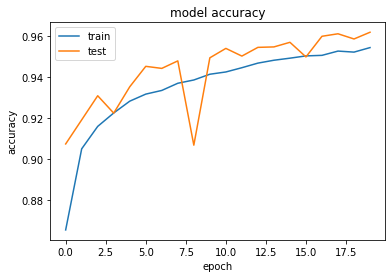

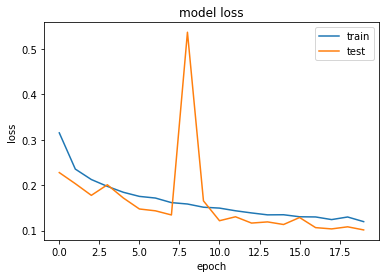

In [22]:
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

##Evaluating Best Accuracy on Validation Set

In [23]:
val_loss, val_acc = \
model1.evaluate_generator(validation_generator)
print('val_loss: ', val_loss)
print('val_acc: ', val_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


val_loss:  0.10232149064540863
val_acc:  0.9617812633514404


##Making Predictions on Validation Set

In [24]:
predictions = model1.predict_generator(validation_generator, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


1000/1000 [==============================] - 90s 89ms/step


In [25]:
validation_generator.class_indices

{'0': 0, '1': 1}

In [26]:
prediction = predictions.flatten()

In [27]:
print(predictions.round(2))

[[0.  ]
 [0.  ]
 [0.  ]
 ...
 [0.99]
 [0.85]
 [0.77]]


In [28]:
predictions = np.where(predictions >0.5, 1, 0) #Converting Prediction in Binary Form
print(predictions)

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


In [29]:
df_preds = pd.DataFrame(predictions) #Putting Predictions In Dataframe
df_preds.head(20)

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [30]:
y_true = validation_generator.classes
y_pred = df_preds

In [31]:
#ROC_AUC Score
print('ROC AUC Score: ', roc_auc_score(y_true, y_pred))

ROC AUC Score:  0.96325


##ROC Graph

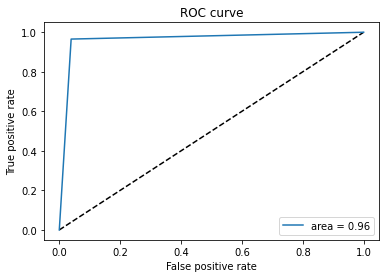

In [32]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.2f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

##Confusion Matrix

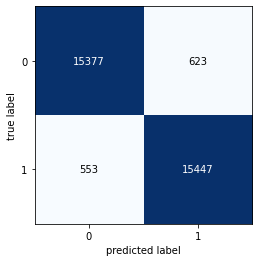

In [33]:
cm = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                # show_absolute=True,
                                # show_normed=True,
                                # colorbar=True,
                              #  cmap = 'Dark2'
                              )
plt.show()

##Classification Report

In [34]:
# Generate a classification report
report = classification_report(y_true, y_pred, target_names = ['no_tumor', 'has_tumor'])
print(report)

              precision    recall  f1-score   support

    no_tumor       0.97      0.96      0.96     16000
   has_tumor       0.96      0.97      0.96     16000

    accuracy                           0.96     32000
   macro avg       0.96      0.96      0.96     32000
weighted avg       0.96      0.96      0.96     32000



In [35]:
model1.save('/content/drive/MyDrive/Colab Notebooks/Models/model1_resnet_adam.h5') #Saving Model

In [ ]:
# predictions.shape

In [ ]:
# df_preds = pd.DataFrame(predictions)
# df_preds.head(20)


In [ ]:
# len(df_preds)

In [ ]:
# p_pred = model.predict(X_test)
# p_pred = p_pred.flatten()
# print(p_pred.round(2))
# # [1. 0.01 0.91 0.87 0.06 0.95 0.24 0.58 0.78 ...

# # extract the predicted class labels
# y_pred = np.where(p_pred > 0.5, 1, 0)
# print(y_pred)
# # [1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 ...

# print(confusion_matrix(y_test, y_pred))

In [ ]:
# # Model-2
# model2 = Sequential() 

# model2.add(Conv2D(64,(3,3), activation = 'relu', padding = 'same', input_shape = (96,96,3)))
# model2.add(MaxPooling2D(pool_size=(2,2)))
# model2.add(Dropout(0.20))
# model2.add(Conv2D(128,(3,3), activation = 'relu', padding = 'same'))
# model2.add(Dropout(0.25))
# model2.add(Conv2D(256,(3,3), activation = 'relu', padding = 'same'))
# model2.add(MaxPooling2D(pool_size=(2,2)))
# model2.add(Dropout(0.25))
# model2.add(Conv2D(512,(3,3), activation = 'relu', padding = 'same'))
# model2.add(Dropout(0.25))
# model2.add(Conv2D(1024,(3,3), activation = 'relu', padding = 'same'))
# model2.add(MaxPooling2D(pool_size=(2,2)))
# model2.add(Flatten())
# model2.add(Dense(1, activation = 'sigmoid'))


# model2.summary()
# model2.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits= False), optimizer ='adam', metrics=['accuracy'])

# callback = EarlyStopping(monitor='val_accuracy', patience=5)

# seed = 1234
# np.random.seed(seed)
# history2 = model2.fit(train_generator, validation_data=(validation_generator), epochs=20, batch_size=32, callbacks=[callback])

In [ ]:
# plt.plot(history2.history['accuracy'])
# plt.plot(history2.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history2.history['loss'])
# plt.plot(history2.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
# plt.show()

In [ ]:
# # Model-9
# model9 = Sequential() 

# model9.add(Conv2D(64,(3,3), activation = 'relu', padding = 'same', input_shape = (96,96,3)))
# model9.add(MaxPooling2D(pool_size=(2,2)))
# model9.add(Dropout(0.20))
# model9.add(Conv2D(128,(3,3), activation = 'relu', padding = 'same'))
# model9.add(Dropout(0.25))
# model9.add(Conv2D(256,(3,3), activation = 'relu', padding = 'same'))
# model9.add(MaxPooling2D(pool_size=(2,2)))
# model9.add(Dropout(0.25))
# model9.add(Conv2D(512,(3,3), activation = 'relu', padding = 'same'))
# model9.add(Dropout(0.25))
# model9.add(Conv2D(1024,(3,3), activation = 'relu', padding = 'same'))
# model9.add(MaxPooling2D(pool_size=(2,2)))
# model9.add(Flatten())
# model9.add(Dense(2, activation = 'softmax'))


# model9.summary()
# model9.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer ='adam', metrics=['accuracy'])

# callback = EarlyStopping(monitor='val_accuracy', patience=5)

# seed = 1234
# np.random.seed(seed)
# history9 = model9.fit(train_generator, validation_data=(validation_generator), epochs=20, batch_size=64, callbacks=[callback])

In [ ]:
# plt.plot(history9.history['accuracy'])
# plt.plot(history9.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history9.history['loss'])
# plt.plot(history9.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
# plt.show()

## 2. DenseNet-121

In [34]:
DenseNet121 = tf.keras.applications.DenseNet121(input_shape = (96,96,3),
                                                include_top=False,
                                                weights='imagenet')
mod1=DenseNet121.output
mod1=tf.keras.layers.Flatten()(mod1)
mod1=tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(mod1)
output1=tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)(mod1)
model77=tf.keras.models.Model(inputs=DenseNet121.inputs,outputs=output1)

model77.compile(optimizer=tf.keras.optimizers.Adam(0.000005),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])
model77.summary()

callback = EarlyStopping(monitor='val_accuracy', patience=5)

seed = 1234
np.random.seed(seed)
hist77 = model77.fit(train_generator, validation_data=(validation_generator), epochs=20, batch_size=32, callbacks=[callback])

29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 48, 48, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1/conv[0][0]']             
                             

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
5000/5000 [==============================] - 716s 141ms/step - loss: 0.4220 - accuracy: 0.8070 - val_loss: 0.3288 - val_accuracy: 0.8565
Epoch 2/20
5000/5000 [==============================] - 714s 143ms/step - loss: 0.3252 - accuracy: 0.8586 - val_loss: 0.2787 - val_accuracy: 0.8815
Epoch 3/20
5000/5000 [==============================] - 706s 141ms/step - loss: 0.2895 - accuracy: 0.8780 - val_loss: 0.2502 - val_accuracy: 0.8972
Epoch 4/20
5000/5000 [==============================] - 699s 140ms/step - loss: 0.2639 - accuracy: 0.8902 - val_loss: 0.2278 - val_accuracy: 0.9070
Epoch 5/20
5000/5000 [==============================] - 698s 140ms/step - loss: 0.2474 - accuracy: 0.8984 - val_loss: 0.2126 - val_accuracy: 0.9152
Epoch 6/20
5000/5000 [==============================] - 696s 139ms/step - loss: 0.2340 - accuracy: 0.9039 - val_loss: 0.1989 - val_accuracy: 0.9199
Epoch 7/20
5000/5000 [==============================] - 687s 137ms/step - loss: 0.2215 - accuracy: 0.9097 - val_

##Making Model Accuracy and Loss Graph


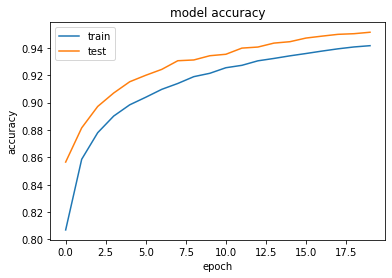

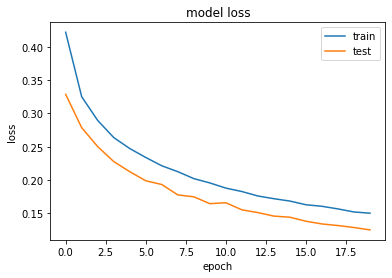

In [35]:
plt.plot(hist77.history['accuracy'])
plt.plot(hist77.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist77.history['loss'])
plt.plot(hist77.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

##Evaluating Best Accuracy on Validation Set

In [36]:
val_loss, val_acc = \
model77.evaluate_generator(validation_generator)
print('val_loss: ', val_loss)
print('val_acc: ', val_acc)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


val_loss:  0.12863478064537048
val_acc:  0.9508125185966492


##Making Predictions on Validation Set

In [37]:
predictions = model77.predict_generator(validation_generator, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


1000/1000 [==============================] - 96s 94ms/step


In [38]:
predictions.shape
validation_generator.class_indices

{'0': 0, '1': 1}

In [39]:
prediction = predictions.flatten()
print(predictions.round(2))

[[0.  ]
 [0.01]
 [0.  ]
 ...
 [0.95]
 [1.  ]
 [0.73]]


In [40]:
predictions = np.where(predictions >0.5, 1, 0) #Converting Prediction in Binary Form
print(predictions)

[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


In [41]:
df_preds = pd.DataFrame(predictions) #Putting Predictions In Dataframe
df_preds.head(20)

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [42]:
y_true = validation_generator.classes
y_pred = df_preds

In [43]:
#ROC_AUC Score
print('ROC AUC Score: ', roc_auc_score(y_true, y_pred))

ROC AUC Score:  0.95121875


##ROC Graph

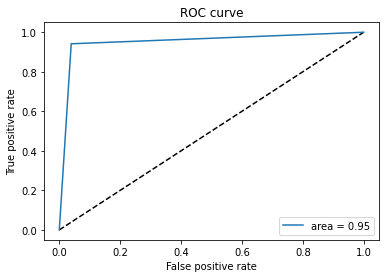

In [44]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.2f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

##Confusion Matrix

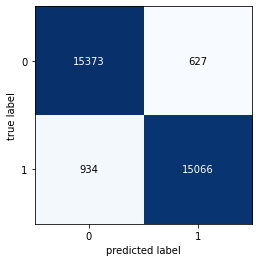

In [45]:
cm = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                # show_absolute=True,
                                # show_normed=True,
                                # colorbar=True,
                              #  cmap = 'Dark2'
                              )
plt.show()

##Classification Report

In [46]:
# Generate a classification report
report = classification_report(y_true, y_pred, target_names = ['no_tumor', 'has_tumor'])
print(report)

              precision    recall  f1-score   support

    no_tumor       0.94      0.96      0.95     16000
   has_tumor       0.96      0.94      0.95     16000

    accuracy                           0.95     32000
   macro avg       0.95      0.95      0.95     32000
weighted avg       0.95      0.95      0.95     32000



In [47]:
model77.save('/content/drive/MyDrive/Colab Notebooks/Models/model_dense_adam.h5') #Saving the Model

In [ ]:
# EfficientNetB7=tf.keras.applications.efficientnet.EfficientNetB7(input_shape=(96,96,3),
#                                                include_top=False,
#                                                weights='imagenet')
# mod1=EfficientNetB7.output
# mod1=tf.keras.layers.Flatten()(mod1)
# mod1=tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(mod1)
# output1=tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)(mod1)
# model7= tf.keras.models.Model(inputs=EfficientNetB7.inputs,outputs=output1)

# model7.compile(optimizer=tf.keras.optimizers.Adam(0.00005),
#              loss=tf.keras.losses.BinaryCrossentropy(from_logits= False),
#              metrics=['accuracy'])
# model7.summary()

# callback = EarlyStopping(monitor='val_accuracy', patience=5)

# seed = 1234
# np.random.seed(seed)
# hist7 = model7.fit(train_generator, validation_data=(validation_generator), epochs=20, batch_size=32, callbacks=[callback])

In [ ]:
# plt.plot(hist77.history['accuracy'])
# plt.plot(hist77.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(hist77.history['loss'])
# plt.plot(hist77.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right')
# plt.show()


# val_loss, val_acc = \
# model1.evaluate_generator(validation_generator)
# print('val_loss: ', val_loss)
# print('val_acc: ', val_acc)

# predictions = model1.predict_generator(validation_generator, verbose=1)

# predictions.shape

# validation_generator.class_indices

# prediction = predictions.flatten()
# print(predictions.round(2))

# predictions = np.where(predictions >0.5, 1, 0)
# print(predictions)

# df_preds = pd.DataFrame(predictions)
# df_preds.head(20)

# y_true = validation_generator.classes
# y_pred = df_preds


# print('ROC AUC Score: ', roc_auc_score(y_true, y_pred))

# fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)
# auc_keras = auc(fpr_keras, tpr_keras)

# plt.figure(1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='area = {:.2f}'.format(auc_keras))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()


# # For this to work we need y_pred as binary labels not as probabilities
# # y_pred_binary = predictions.argmax(axis=1)
# cm = confusion_matrix(y_true, y_pred)
# fig, ax = plot_confusion_matrix(conf_mat=cm,
#                                 # show_absolute=True,
#                                 # show_normed=True,
#                                 # colorbar=True,
#                               #  cmap = 'Dark2'
#                               )
# plt.show()


# # Generate a classification report
# report = classification_report(y_true, y_pred, target_names = ['no_tumor', 'has_tumor'])
# print(report)